In [1]:
import awkward as ak
import numpy as np
import hist as hs
from coffea import processor, hist as chs
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.CMS)

/uscms_data/d3/aaportel/mambaforge/envs/analysis-env/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [46]:
class LLP_ntuple_processor(processor.ProcessorABC):
    """
    This class is used to process the ntuples created by the LLP ntuple producer.
    """
    
    global a # don't do this
    a = 1

    def acc_cut(self, events):

        cut = (events.gLLP_csc == 1)
        return events[cut]
        #return events[ak.any(cut, axis = -1)]

    def met_cut(self, events):
        cut = events.metEENoise >= 30
        return events[cut]

    def csc_eff_cut(self, events):
        
        cut = (events.nCscRechitClusters >= 1)
        return events[cut]

    def muon_veto(self, events):
        
        cut = (events.cscRechitClusterMuonVetoPt < 20)
        return events[ak.any(cut, axis = a)]

    def jet_cut(self, events):
        
        cut = (events.cscRechitClusterJetVetoPt < 10)
        return events[ak.any(cut, axis = a)]

    def time_cut(self, events):

        cut = ((events.cscRechitClusterTimeWeighted <= 12.5)&
               (events.cscRechitClusterTimeWeighted >= -5  ))
        return events[ak.any(cut, axis = a)]

    def ME11_veto(self, events):

        cut = ((events.cscRechitClusterNRechitChamberPlus11 <= 0)&
               (events.cscRechitClusterNRechitChamberMinus11 <= 0))
        return events[ak.any(cut, axis = a)]


    def ME12_veto(self, events):

        cut = ((events.cscRechitClusterNRechitChamberPlus12 <= 0)&
               (events.cscRechitClusterNRechitChamberMinus12 <= 0))
        return events[ak.any(cut, axis = a)]


    def re12_cut(self, events):
        
        cut = events.cscRechitCluster_match_RE12_0p4 == 0
        return events[ak.any(cut, axis = a)]

    def mb1_cut(self, events):
        
        cut = events.cscRechitCluster_match_MB1Seg_0p4 == 0
        return events[ak.any(cut, axis = a)]

    def rb1_cut(self, events):
        
        cut = events.cscRechitCluster_match_RB1_0p4 == 0
        return events[ak.any(cut, axis = a)]

    def eta_cut(self, events):
        
        cut = abs(events.gLLP_eta) < 2 
        return events[cut]

    def time_spread_cut(self, events):
    
        cut = events.cscRechitClusterTimeSpreadWeightedAll <= 20
        return events[ak.any(cut, axis = a)]

    def cut_based(self, events):
    
        cut = (((events.cscRechitClusterNStation10 > 1) & (abs(events.cscRechitClusterEta) < 1.9))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 4) & (abs(events.cscRechitClusterEta) < 1.8))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 3) & (abs(events.cscRechitClusterEta) < 1.6))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 2) & (abs(events.cscRechitClusterEta) < 1.6))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 1) & (abs(events.cscRechitClusterEta) < 1.1))
            )
        return events[ak.any(cut, axis = a)]

    def dphi_cut(self, events):
    
        cut = abs(events.cscRechitClusterMetEENoise_dPhi) < 0.75
        return events[ak.any(cut, axis = a)]

    def nrechits_cut(self, events):

        cut = events.cscRechitClusterSize > 130
        return events[ak.any(cut, axis = a)]


    def muon_cls_deltaR(self, events):
        
        clusts = ak.zip(
            {
                'pt': ak.ones_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'mass': ak.ones_like(events.cscRechitClusterPhi),
                'E': ak.ones_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )

        muoncut = abs(events.lepPdgId) == 13
        muons = ak.zip(
            {
                'pt': events.lepPt[muoncut],
                'phi': events.lepPhi[muoncut],
                'eta': events.lepEta[muoncut],
                'mass': ak.ones_like(events.lepPhi[muoncut]),
                'E': events.lepE[muoncut],
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        leadcut = ak.max(muons.pt, 1) == muons.pt
        muons = muons[leadcut]
        
        muon_cls_pairs = ak.cartesian({
            "clusts": clusts, 
            "muons": muons
        }, axis = 1, nested = True)
        
        deltaR = (muon_cls_pairs.clusts).delta_r(muon_cls_pairs.muons)
        deltaEta = abs(muon_cls_pairs.clusts.eta - muon_cls_pairs.muons.eta)
        deltaPhi = np.arctan2(np.sin(muon_cls_pairs.clusts.phi - muon_cls_pairs.muons.phi), 
                              np.cos(muon_cls_pairs.clusts.phi - muon_cls_pairs.muons.phi))
               
        return deltaR, deltaEta, deltaPhi

    
    def process(self, events):

        dataset = events.metadata['dataset']
        out = {
            dataset: {
                "entries": len(events),
            }
        }
        
        # cheeky way of sequentially adding cuts to events
        #cuts = [self.acc_cut, self.csc_eff_cut, self.muon_veto, self.jet_cut, self.time_cut, self.ME11_veto, self.ME12_veto, self.re12_cut, self.mb1_cut, self.rb1_cut, self.eta_cut, self.time_spread_cut, self.cut_based, self.dphi_cut, self.nrechits_cut]
        cuts = [self.acc_cut, self.ME11_veto, self.ME12_veto, self.re12_cut, self.mb1_cut, self.rb1_cut]

        last = events

        def histsaver(out, last, cut):
            
            deltaR, deltaEta, deltaPhi= self.muon_cls_deltaR(last)
            deltaRcut = deltaR > 1
            timecut = ((last.cscRechitClusterTimeTotal >= -5) & (last.cscRechitClusterTimeTotal <= 12.5))
            clsCuts = timecut & deltaRcut
            #deltaRcut = ak.values_astype(ak.ones_like(last.metEENoise), 'bool') #deltaRcut override
            
            out[dataset][cut] = len(last)
            out[dataset][f'{cut}_met'] = hs.Hist.new.Reg(30, 0, 100, name='met', label='MET [GeV]').Double()
            out[dataset][f'{cut}_dphi'] = hs.Hist.new.Reg(30, 0, 5, name='dPhi', label='dPhi').Double()
            out[dataset][f'{cut}_timeSpread'] = hs.Hist.new.Reg(30, 0, 20, name='timeSpread', label='time').Double()
            out[dataset][f'{cut}_clsEta'] = hs.Hist.new.Reg(30, 0, 4, name='clsEta', label='eta').Double()
            out[dataset][f'{cut}_clsTimeTotal'] = hs.Hist.new.Reg(30, -5.5, 13, name='clsTimeTotal', label='time').Double()

            out[dataset][f'{cut}_met'].fill(ak.flatten(last.metEENoise.mask[clsCuts], axis=None))
            out[dataset][f'{cut}_dphi'].fill(ak.flatten(last.cscRechitClusterMetEENoise_dPhi.mask[clsCuts], axis=None))
            out[dataset][f'{cut}_timeSpread'].fill(ak.flatten(last.cscRechitClusterTimeSpreadWeightedAll.mask[clsCuts], axis=None))
            out[dataset][f'{cut}_clsEta'].fill(ak.flatten(abs(last.cscRechitClusterEta.mask[clsCuts]), axis=None))        
            out[dataset][f'{cut}_clsTimeTotal'].fill(ak.flatten(last.cscRechitClusterTimeTotal.mask[clsCuts], axis=None))         

            #~~~~~~~

            out[dataset][f'{cut}_deltaR_muon_cls'] = hs.Hist.new.Reg(30, 0, 4, name='deltaR_muon_cls', label='deltaR_muon_cls').Double()
            out[dataset][f'{cut}_deltaEta_muon_cls'] = hs.Hist.new.Reg(30, 0, 4, name='deltaEta_muon_cls', label='deltaEta_muon_cls').Double()
            out[dataset][f'{cut}_deltaPhi_muon_cls'] = hs.Hist.new.Reg(30, 0, 4, name='deltaPhi_muon_cls', label='deltaPhi_muon_cls').Double()

            out[dataset][f'{cut}_deltaR_muon_cls'].fill(ak.flatten(deltaR.mask[deltaRcut], axis=None))
            out[dataset][f'{cut}_deltaEta_muon_cls'].fill(ak.flatten(deltaEta.mask[clsCuts], axis=None))
            out[dataset][f'{cut}_deltaPhi_muon_cls'].fill(ak.flatten(deltaPhi.mask[clsCuts], axis=None))
            
        histsaver(out, last, 'total')
        
        for cut in cuts:
            try:
                last = cut(last)
            except:
                last = last
                
            histsaver(out, last, cut.__name__)
            


        return out   
    
    def postprocess(self, accumulator):
        return accumulator

In [47]:
fileset = {}
fileset['signal']     = ['root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v3/normalized/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root',]
fileset['background'] = ['root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/csc/V1p171/Data2018_UL/v3/normalized/ParkingBPH4_Run2018A_goodLumi.root']
out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 16},
    #maxchunks = 1
)

cuts = ['total', 'acc_cut', 'ME11_veto', 'ME12_veto', 're12_cut', 'mb1_cut', 'rb1_cut']

Output()

In [48]:
from hist.intervals import ratio_uncertainty
def ratio(num, den, ax):
    ax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view()),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return ax


/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_29546/4019254757.py:5: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


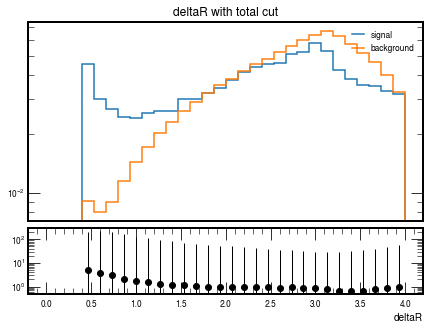

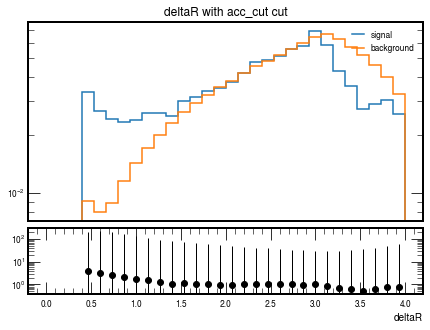

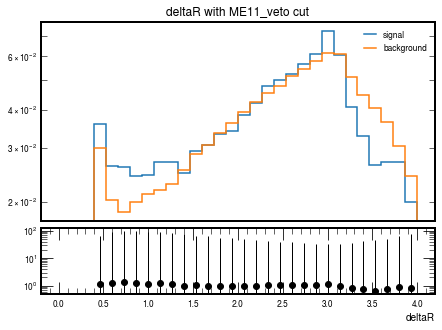

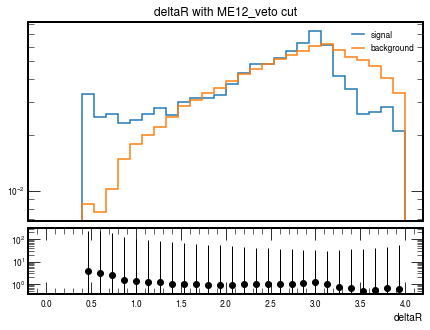

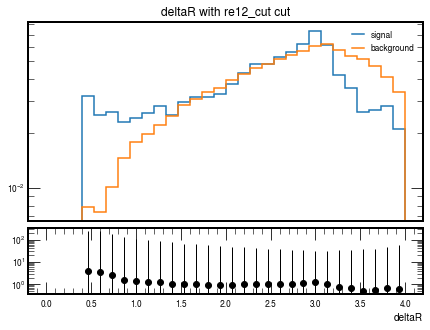

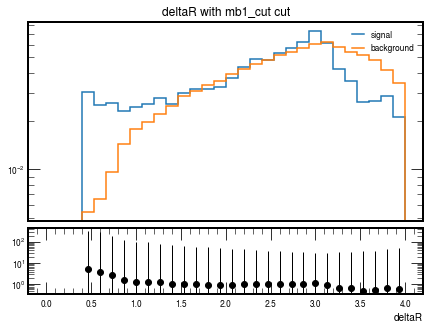

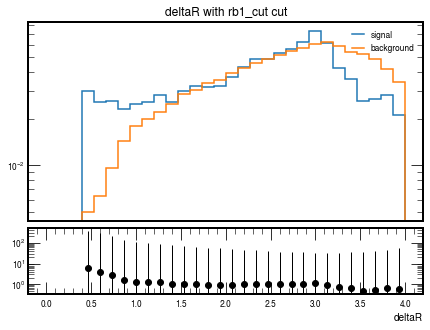

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

varname = 'deltaR'

#pdf = PdfPages(f'{varname}_cutflow_sb.pdf')

l = len(cuts)
for cut in cuts:
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))
    
    signal = out['signal'][f'{cut}_{varname}_muon_cls']
    background = out['background'][f'{cut}_{varname}_muon_cls']

    hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
    hep.histplot(background/background.sum(), label='background', ax=ax[0])
    ax[0].set_title(f'{varname} with {cut} cut')
    ax[0].legend()
    ax[0].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax[0].set(xlabel=None)
    ax[0].set_yscale('log')
    
    ratio(signal/signal.sum(), background/background.sum(), ax[1])
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set(xlabel=varname)
    ax[1].set_yscale('log')
    fig.subplots_adjust(wspace=0, hspace=.05)
#    pdf.savefig(fig)
#pdf.close()


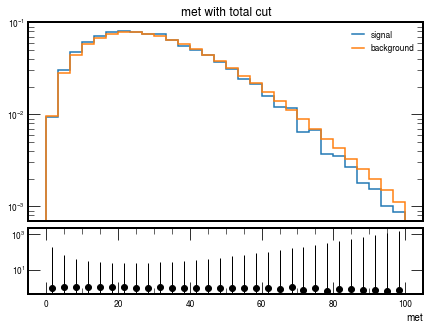

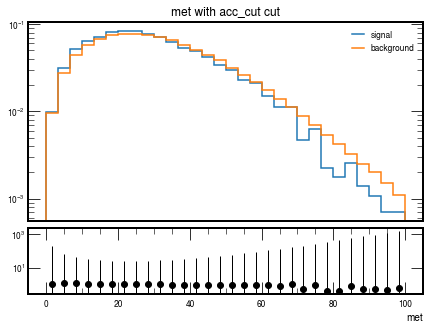

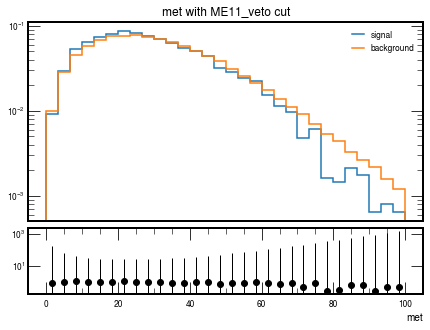

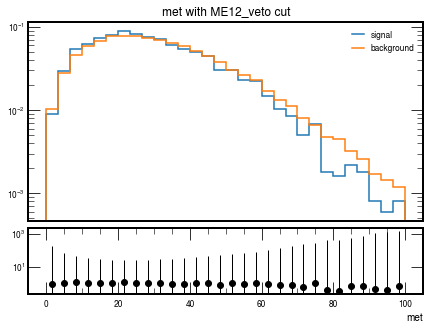

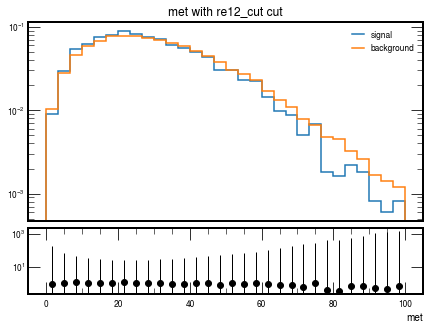

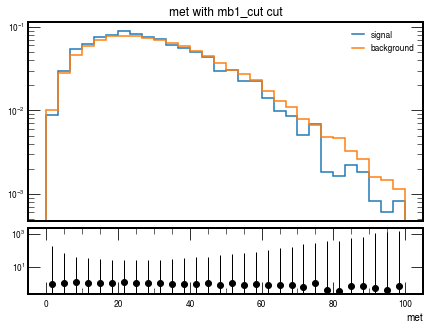

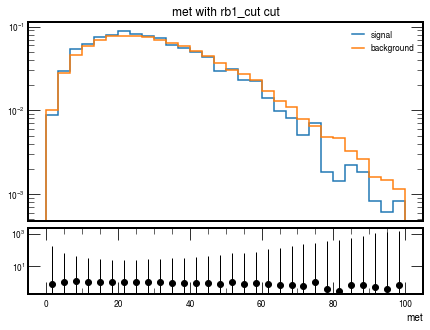

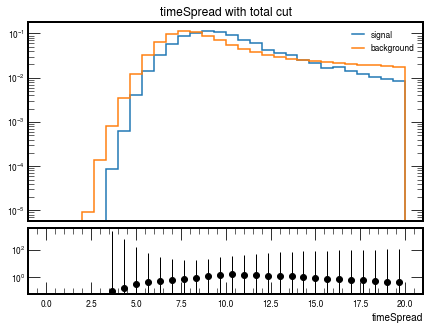

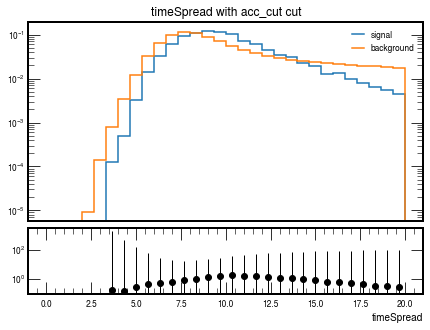

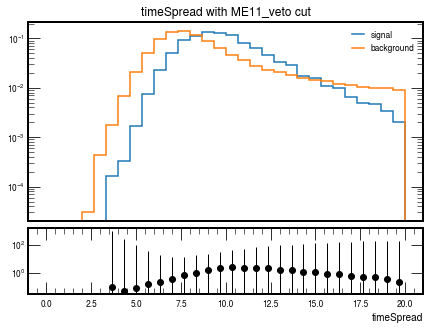

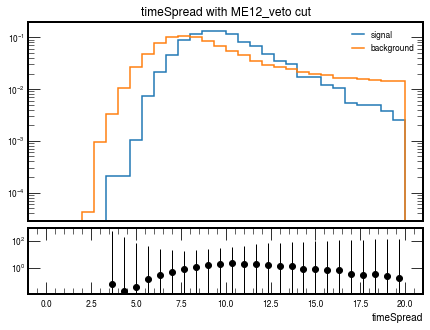

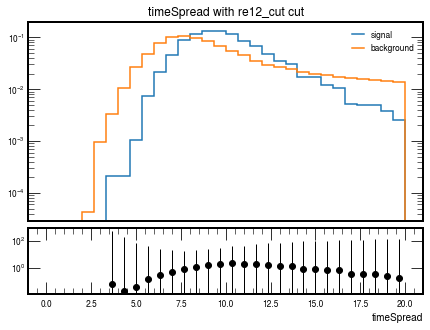

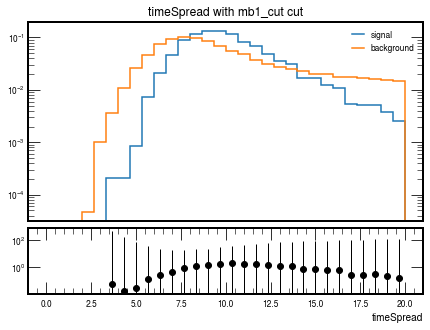

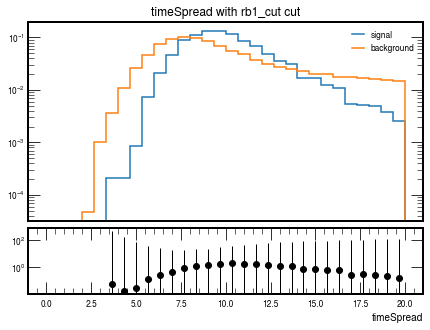

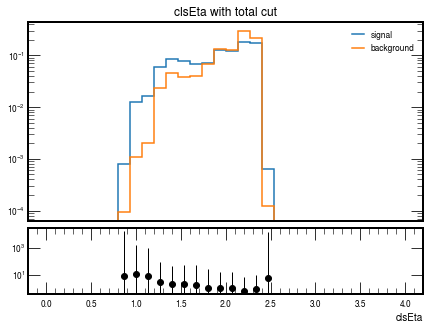

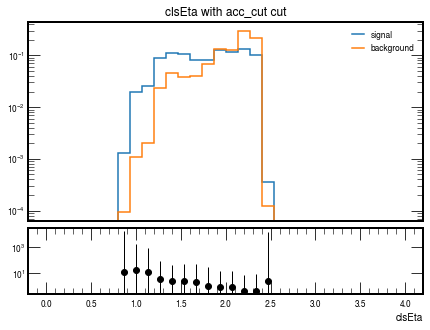

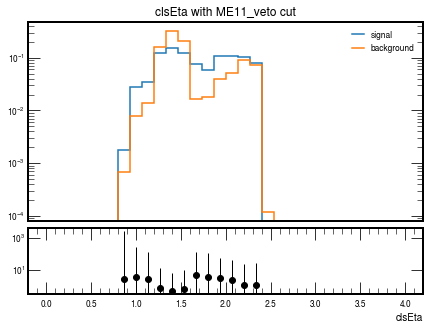

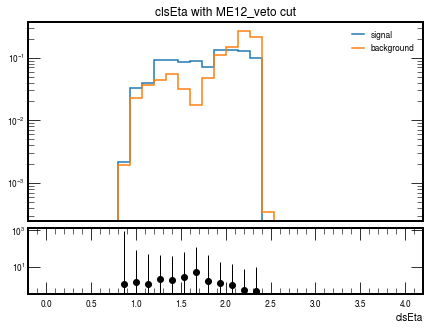

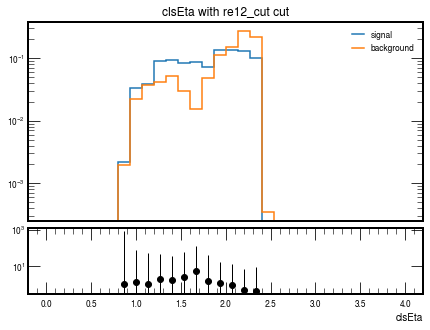

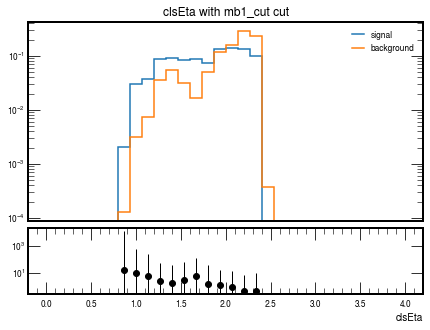

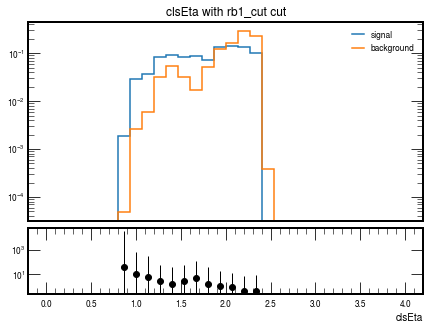

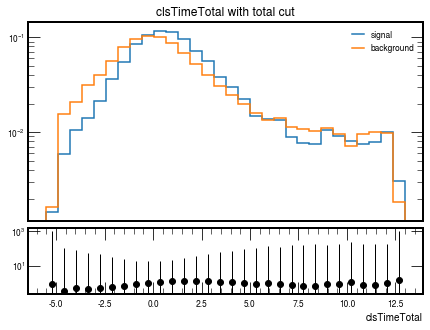

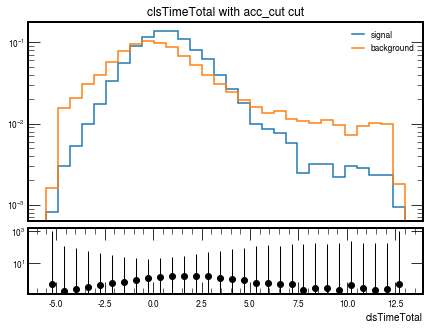

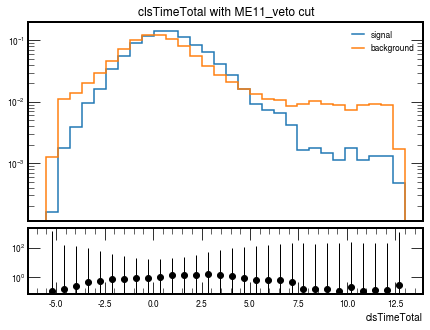

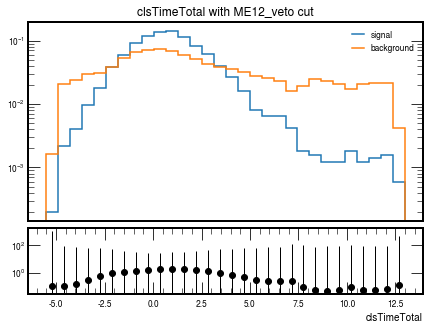

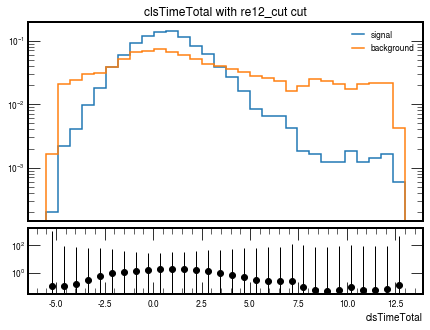

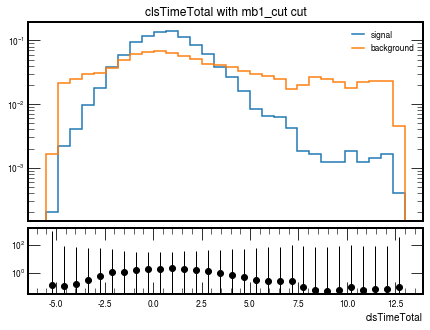

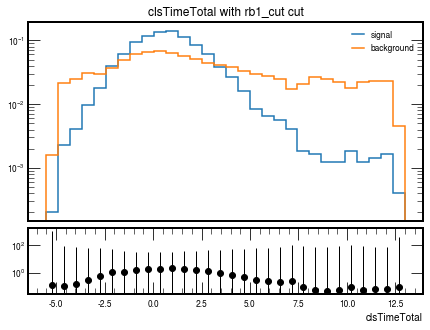

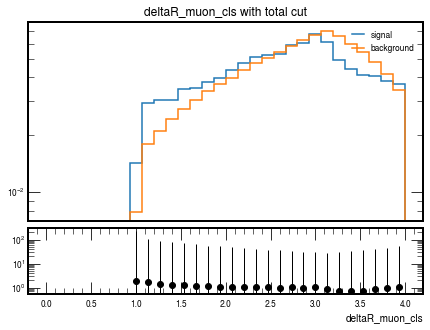

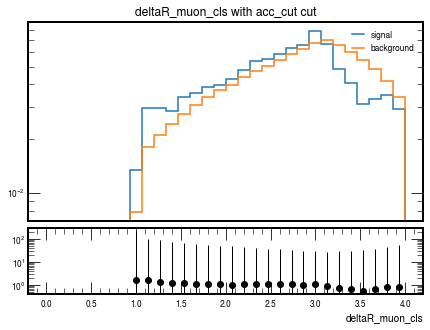

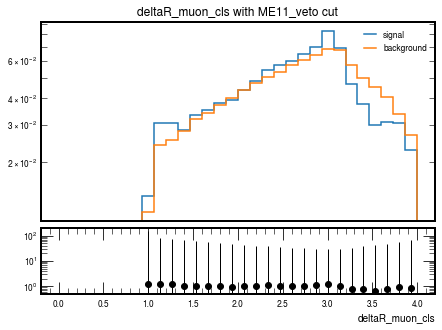

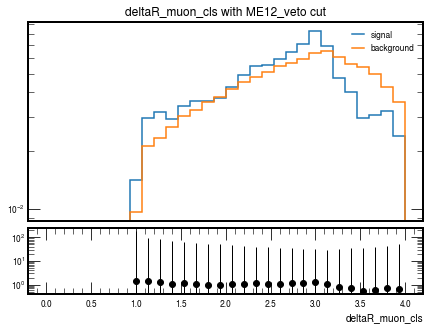

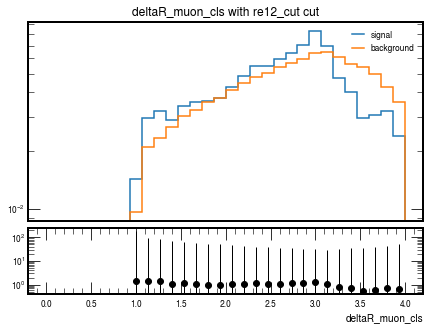

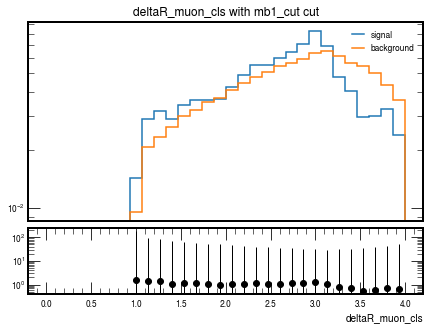

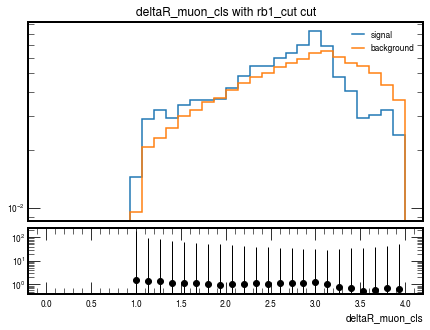

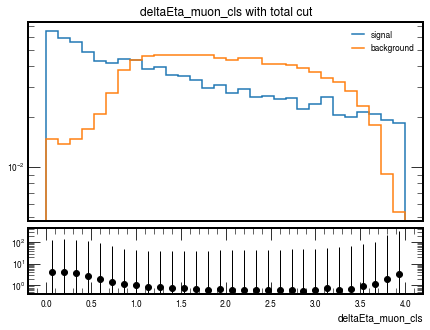

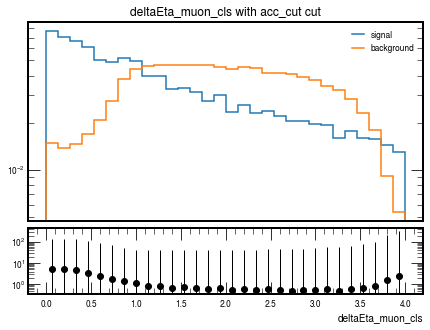

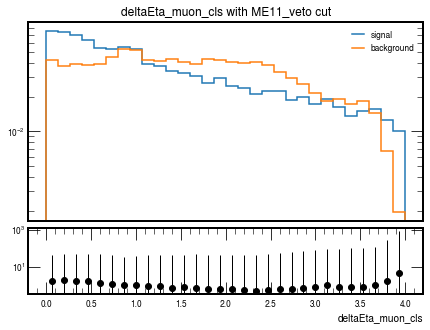

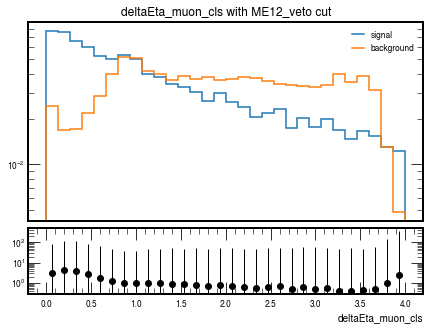

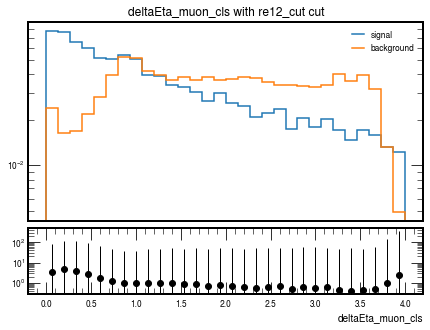

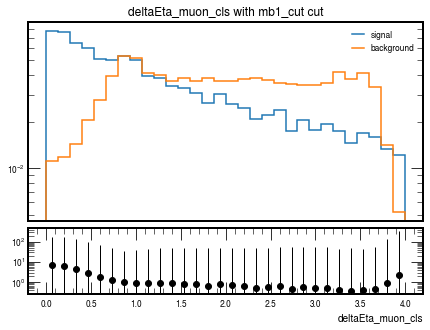

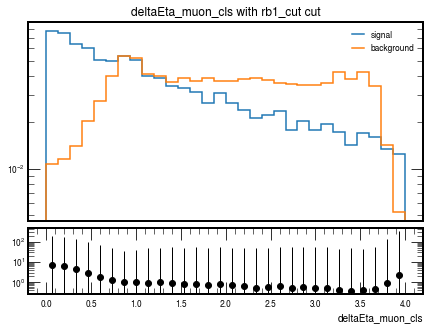

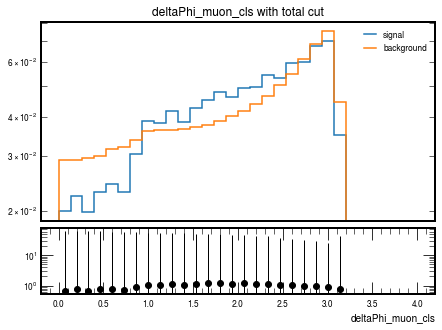

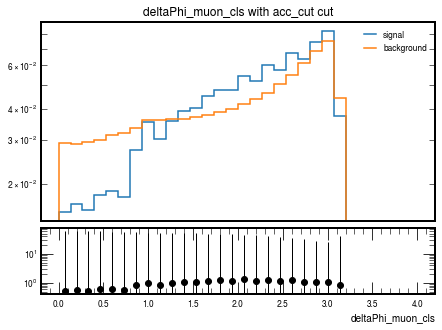

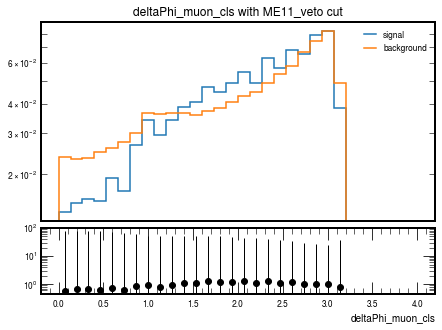

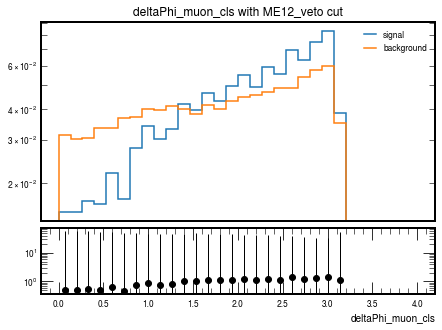

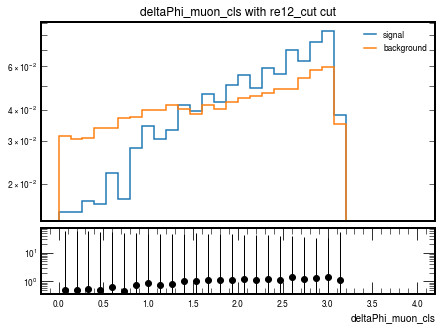

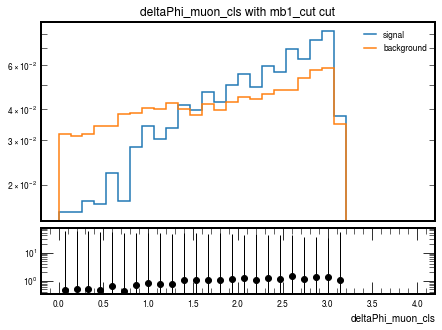

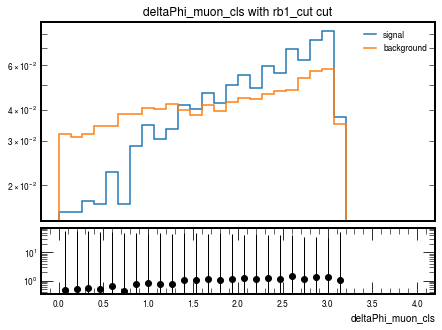

In [50]:
from matplotlib.backends.backend_pdf import PdfPages
import warnings

with warnings.catch_warnings(): #i don't need to see all the divide by zero warnings
    warnings.simplefilter("ignore")
    
    varnames = ['met', 'timeSpread', 'clsEta', 'clsTimeTotal', 'deltaR_muon_cls', 'deltaEta_muon_cls', 'deltaPhi_muon_cls']

    for varname in varnames:
        pdf = PdfPages(f'varPlots_sb_clsCuts_07_28_22/{varname}_cutflow_sb.pdf')

        for cut in cuts:
            fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))

            signal = out['signal'][f'{cut}_{varname}']
            background = out['background'][f'{cut}_{varname}']

            hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
            hep.histplot(background/background.sum(), label='background', ax=ax[0])
            ax[0].set_title(f'{varname} with {cut} cut')
            ax[0].legend()
            ax[0].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax[0].set(xlabel=None)
            ax[0].set_yscale('log')

            ratio(signal/signal.sum(), background/background.sum(), ax[1])
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].set(xlabel=varname)
            ax[1].set_yscale('log')
            fig.subplots_adjust(wspace=0, hspace=.05)
            pdf.savefig(fig)
        pdf.close()
